In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from scipy import stats

We have created our classes for the value of the home in this project's main notebook rather arbitrarily. The goal of this notebook is to determine if the data supports that these classes are in fact different.

In [2]:
dat = pd.concat([pd.read_csv('ss15hnd.csv'), pd.read_csv('ss15hny.csv'),
                 pd.read_csv('ss15hwy.csv'),
                 pd.read_csv('ss15htx.csv')], ignore_index = True)
dat.rename(columns = {"insp": "INSP"}, inplace = True)

colnames = ["ST", "NP", "ACR", "BATH", "BDSP", "ELEP", "GASP", "INSP",
              "RMSP", "RWAT", "SINK", "VALP", "VEH", "WATP", "YBL", "HINCP"]
readable_names = ["State", "Num_People", "Lot_Size", "Has_Bathtub", "Num_Bedrooms",
                  "Monthly_Electric", "Monthly_Gas", "Yearly_Insurance_Cost", "Num_Rooms",
                  "Has_Hot_Water", "Has_Sink", "Price", "Num_Vehicles",
                  "Yearly_Water", "Year_Built", "Household_Income"]

cols = dat[colnames]
cols.columns = readable_names
cols.dropna(inplace = True)

cols = pd.get_dummies(cols, columns = ["State"])
readable_names = readable_names[1:]
states =["NY", "ND", "TX", "WY"]
readable_names.extend(states)
cols.columns = readable_names

codes = list(range(1,20))
ages = [90] + [i*10 for i in reversed(range(2,8))] + [13] + list(reversed(range(11)))
for code, age in zip(codes, ages):
    cols.Year_Built[cols.Year_Built == code] = age
cols.rename(columns={"Year_Built":"Age"}, inplace = True)

for col in ["Monthly_Electric", "Monthly_Gas", "Yearly_Insurance_Cost", "Yearly_Water"]:
    cols.loc[:,col] *= dat.loc[cols.index, 'ADJHSG'] * 10**-6
    
cols.Household_Income *= dat.loc[cols.index, 'ADJINC'] * 10**-6

cols['Mobile_Home'] = pd.Series(dat.BLD == 1, dtype = 'int')

cols['Crowding'] = cols.Num_People / cols.Num_Rooms

cols.Num_Rooms -= cols.Num_Bedrooms

X = cols[[col for col in cols if col != 'Price']]
Y = cols.Price

Yclass = np.zeros(len(Y))
Yclass[Y < 10000] = 1
Yclass[(Y>=10000) & (Y<100000)] = 2
Yclass[(Y>=100000) & (Y<500000)] = 3
Yclass[Y>=500000] = 4

/Users/hunter/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hunter/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Plotting the data in a histogram will show if the housing prices appear to be normally distributed.

mean: 237063.62253327988


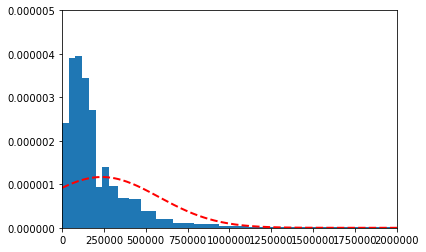

In [3]:
%matplotlib inline

mu = np.mean(Y)
sigma = np.std(Y)
bins = np.append(np.linspace(100,200000,5, endpoint=False),np.geomspace(200000,Y.max(),20))

plt.hist(Y, bins = bins, normed = True)
x = np.linspace(0, Y.max(), 500)
y = mlab.normpdf(x,mu,sigma)
plt.plot(x,y,'r--',linewidth=2)
plt.xlim((0,2*10**6))
plt.ylim((0,5*10**-6))

print("mean:", mu)

This observed distribution does not line up with a normal distribution. It is sometimes helpful to transform the target in order to see if the transformed data better fits a normal distribution. We will try to transform the distribution by taking the natural logarithm of the home price.

mean: 11.858877160756318


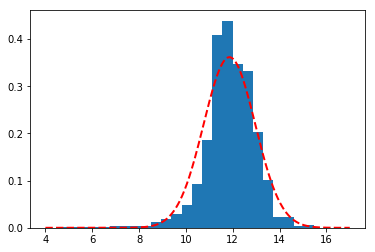

In [4]:
%matplotlib inline

Y = np.log(cols.Price)

mu = np.mean(Y)
sigma = np.std(Y)

plt.hist(Y, bins = 25, normed = True)
x = np.linspace(4, 17, 500)
y = mlab.normpdf(x,mu,sigma)
plt.plot(x,y,'r--',linewidth=2)

print("mean:", mu)

Our goal is to find the features which most highly correlate to price. **Spearman's $\rho$** is a statistical value that shows the strength of the relationship between two numerical variables. An r value near 1 indicates that the variables are strongly positively correlated, an r value near 0 indicates the variables are very weakly correlated, and an r value near -1 indicates that the variables are strongly negatively correlated.

We are using Spearman's correlation coefficient rather than Pearson's r coefficient since some of our variables are ordinal rather than continuous. We lose some statistical power but in addition we also lose the assumption that the variables are correlated linearly.

We will want to see if any of the numerical features in this dataset are highly correlated with price.

In [5]:
numericals = pd.Series(index=['Num_People', 'Lot_Size', 'Num_Bedrooms', 'Monthly_Electric', 'Monthly_Gas', 'Yearly_Insurance_Cost',
                 'Num_Rooms','Num_Vehicles','Yearly_Water','Age','Household_Income','Crowding'])

for index, value in numericals.iteritems():
    numericals[index] = stats.spearmanr(X[index],Y)[0]
    
numerical_df = pd.DataFrame({'truevalues':numericals, 'absvalues':abs(numericals)})
    
numerical_df.sort_values(by='absvalues', ascending=False).truevalues

Yearly_Insurance_Cost    0.588375
Household_Income         0.488422
Num_Bedrooms             0.357388
Num_Rooms                0.317249
Monthly_Electric         0.218194
Num_Vehicles             0.137571
Num_People               0.133119
Monthly_Gas              0.105707
Age                     -0.098152
Crowding                -0.074630
Yearly_Water             0.072626
Lot_Size                 0.013304
Name: truevalues, dtype: float64

For the categorical features, correlation is nonsensical. We may not easily have a  For each feature, we will want to perform a hypothesis test with the null and alternate hypotheses as follows:

$H_0:$ Mean home value is identical for each group in this feature.  
$H_1:$ Mean home value is different for each group in this feature.

We will perform a one-way ANOVA.

In [7]:
categorical_features  = list(set(X.columns) - set(numericals.index))
for feature in categorical_features:
    f, p = stats.f_oneway(X[feature], Y)
    if p < 0.01:
        print("Home value is dependent of {}, f = {}, p = {}".format(feature,f,p))
    else:
        print("Home value is independent of {}, f = {}, p = {}".format(feature,f,p))

Home value is dependent of Has_Sink, f = 51643947.23886792, p = 0.0
Home value is dependent of NY, f = 48647052.7789896, p = 0.0
Home value is dependent of Has_Bathtub, f = 51640555.20996563, p = 0.0
Home value is dependent of ND, f = 60457869.039561406, p = 0.0
Home value is dependent of TX, f = 46469958.74903725, p = 0.0
Home value is dependent of Mobile_Home, f = 58024678.296783365, p = 0.0
Home value is dependent of WY, f = 60737093.214808166, p = 0.0
Home value is dependent of Has_Hot_Water, f = 51596621.98897229, p = 0.0


These test statistics are high enough that the p values are not rendering. Apparently there is some correlation between each of our categorical features, though we do not know the effect size.